In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Wed Jan 24 14:10:13 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [12]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.9999

hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_notconst/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 440475, model_list, optimizer_list)

total 7308
-rw-rw-r-- 1 scpark scpark    6040  1월 24 14:10 events.out.tfevents.1706072935.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7471539  1월 24 14:09 save_0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

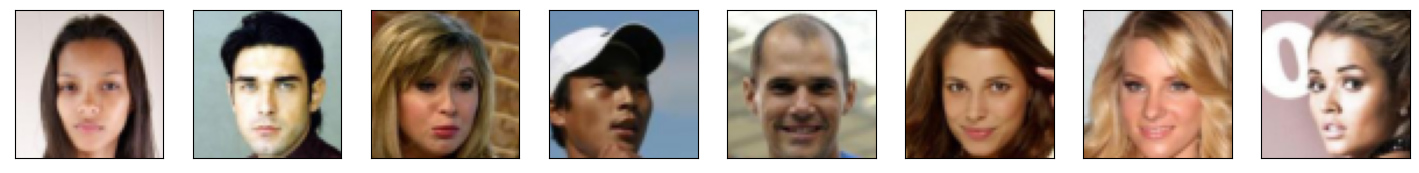

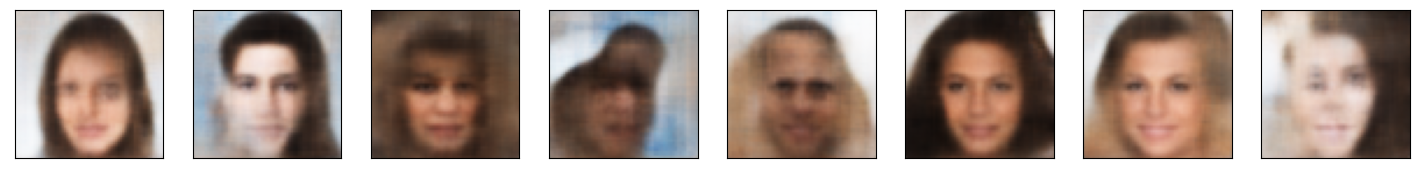

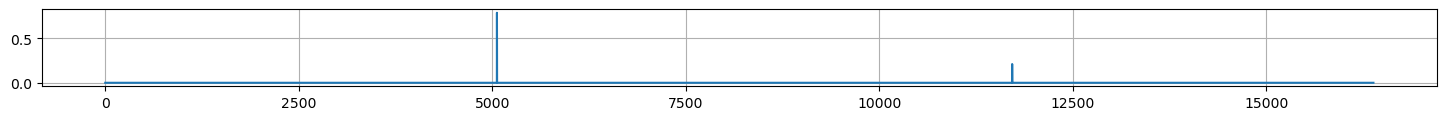

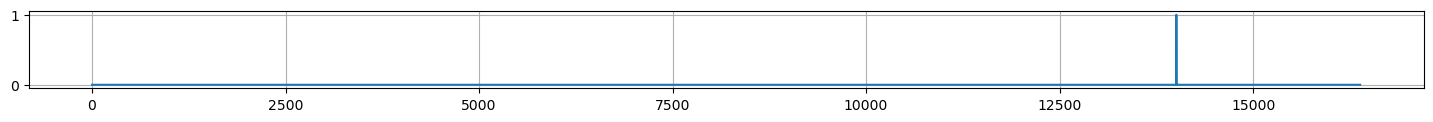

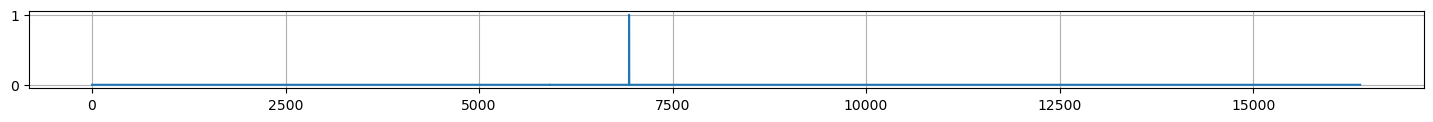

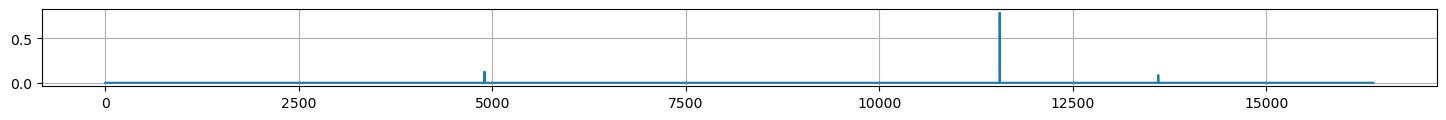

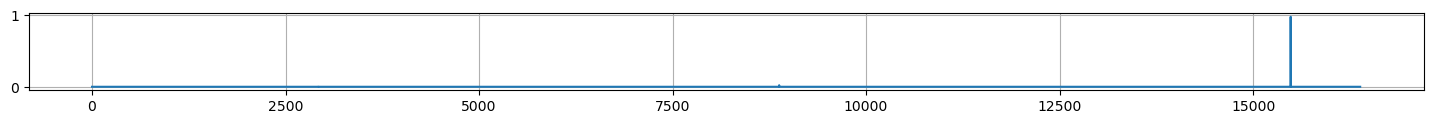

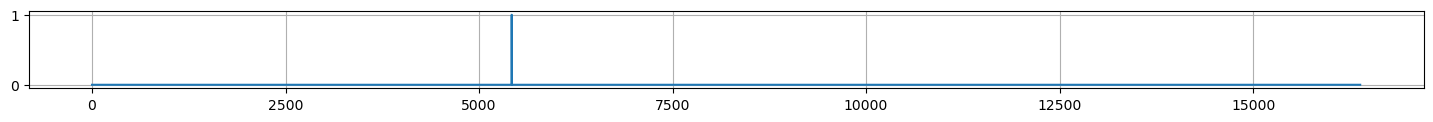

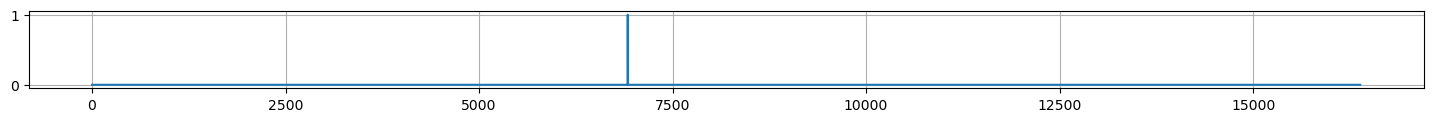

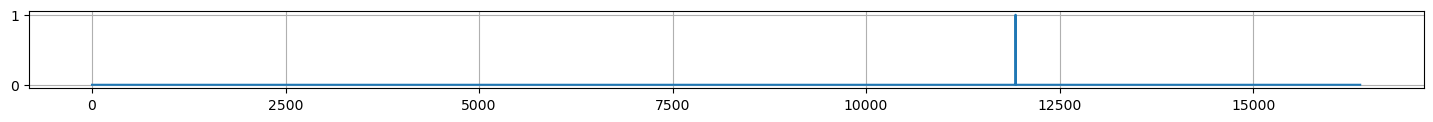

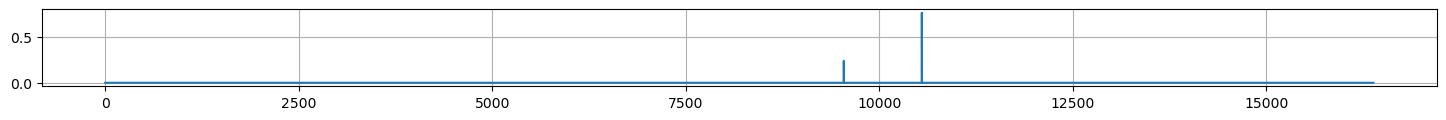

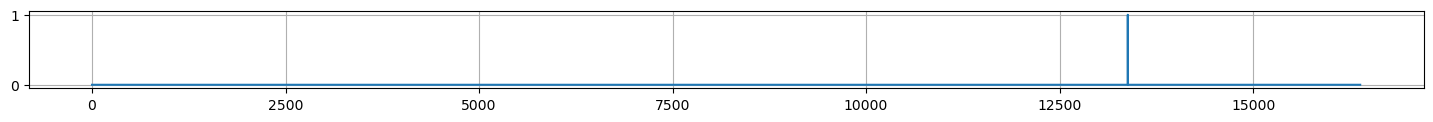

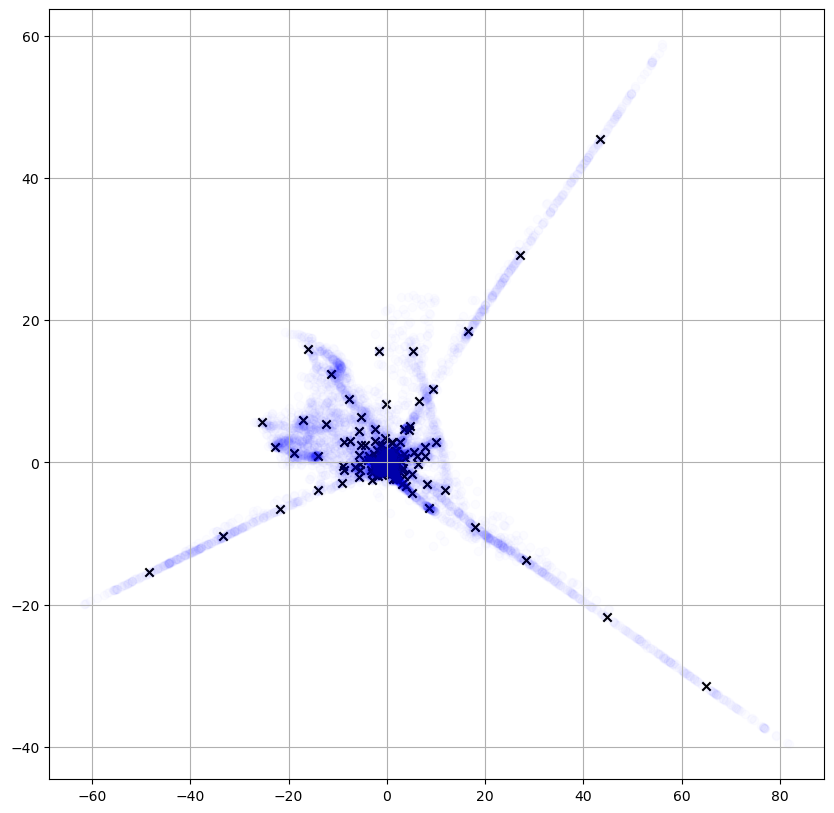

183001
lse_loss -265.88702392578125
commit_loss 0.058544084429740906
recon_loss 0.012674815952777863
183002
lse_loss -271.7249450683594
commit_loss 0.05924109369516373
recon_loss 0.014464217238128185
183003
lse_loss -271.44329833984375
commit_loss 0.05829679220914841
recon_loss 0.015222782269120216
183004
lse_loss -265.3903503417969
commit_loss 0.05611415579915047
recon_loss 0.015317711047828197
183005
lse_loss -274.2667236328125
commit_loss 0.06112460047006607
recon_loss 0.014496788382530212
183006
lse_loss -270.3363952636719
commit_loss 0.05634426325559616
recon_loss 0.013551551848649979
183007
lse_loss -268.1515808105469
commit_loss 0.05183567851781845
recon_loss 0.013906426727771759
183008
lse_loss -268.13214111328125
commit_loss 0.07723310589790344
recon_loss 0.014435892924666405
183009
lse_loss -274.62384033203125
commit_loss 0.062327589839696884
recon_loss 0.015285110101103783
183010
lse_loss -270.5180969238281
commit_loss 0.07312518358230591
recon_loss 0.014272741042077541
1830

183086
lse_loss -275.0523376464844
commit_loss 0.050903964787721634
recon_loss 0.014257952570915222
183087
lse_loss -269.502197265625
commit_loss 0.061195071786642075
recon_loss 0.012726220302283764
183088
lse_loss -272.3905029296875
commit_loss 0.05753343924880028
recon_loss 0.014850553125143051
183089
lse_loss -278.36456298828125
commit_loss 0.06261548399925232
recon_loss 0.01439045649021864
183090
lse_loss -277.4187316894531
commit_loss 0.0495324581861496
recon_loss 0.01446330826729536
183091
lse_loss -260.318115234375
commit_loss 0.09199923276901245
recon_loss 0.013036283664405346
183092
lse_loss -275.6041564941406
commit_loss 0.05005095899105072
recon_loss 0.013910885900259018
183093
lse_loss -269.2805480957031
commit_loss 0.05549655854701996
recon_loss 0.013809106312692165
183094
lse_loss -256.2262268066406
commit_loss 0.06876637041568756
recon_loss 0.014290301129221916
183095
lse_loss -268.8490905761719
commit_loss 0.06095424294471741
recon_loss 0.013399489223957062
183096
lse_l

183171
lse_loss -278.9898376464844
commit_loss 0.055769722908735275
recon_loss 0.013847279362380505
183172
lse_loss -277.7405700683594
commit_loss 0.056489039212465286
recon_loss 0.014911758713424206
183173
lse_loss -279.65118408203125
commit_loss 0.05666784197092056
recon_loss 0.01393449679017067
183174
lse_loss -271.8717346191406
commit_loss 0.06376287341117859
recon_loss 0.015873657539486885
183175
lse_loss -271.7019958496094
commit_loss 0.06298695504665375
recon_loss 0.014012763276696205
183176
lse_loss -271.38543701171875
commit_loss 0.05809621885418892
recon_loss 0.014633502811193466
183177
lse_loss -280.53564453125
commit_loss 0.053539760410785675
recon_loss 0.013441342860460281
183178
lse_loss -269.9577941894531
commit_loss 0.09338629990816116
recon_loss 0.014032721519470215
183179
lse_loss -275.4306945800781
commit_loss 0.05805747210979462
recon_loss 0.013185825198888779
183180
lse_loss -273.2525939941406
commit_loss 0.05413512513041496
recon_loss 0.01478907372802496
183181
ls

183256
lse_loss -270.9302673339844
commit_loss 0.07592152804136276
recon_loss 0.014039397239685059
183257
lse_loss -270.2218933105469
commit_loss 0.07703952491283417
recon_loss 0.015024571679532528
183258
lse_loss -271.16204833984375
commit_loss 0.08165135979652405
recon_loss 0.014519269578158855
183259
lse_loss -272.31927490234375
commit_loss 0.059563878923654556
recon_loss 0.013922721147537231
183260
lse_loss -275.2112121582031
commit_loss 0.07150092720985413
recon_loss 0.015991201624274254
183261
lse_loss -273.8830871582031
commit_loss 0.05620286613702774
recon_loss 0.014119883999228477
183262
lse_loss -275.4510192871094
commit_loss 0.05949164181947708
recon_loss 0.01316530629992485
183263
lse_loss -272.2582702636719
commit_loss 0.08309732377529144
recon_loss 0.015395395457744598
183264
lse_loss -270.29400634765625
commit_loss 0.08651936799287796
recon_loss 0.014255101792514324
183265
lse_loss -277.3860778808594
commit_loss 0.059772610664367676
recon_loss 0.014247015118598938
183266

183341
lse_loss -276.9449768066406
commit_loss 0.05184337496757507
recon_loss 0.013200677931308746
183342
lse_loss -275.4234313964844
commit_loss 0.0481426939368248
recon_loss 0.0135338781401515
183343
lse_loss -273.950927734375
commit_loss 0.06466154754161835
recon_loss 0.014423932880163193
183344
lse_loss -276.66058349609375
commit_loss 0.056482113897800446
recon_loss 0.01363399624824524
183345
lse_loss -274.1243896484375
commit_loss 0.0634574443101883
recon_loss 0.012753630056977272
183346
lse_loss -273.90380859375
commit_loss 0.07335872948169708
recon_loss 0.012855510227382183
183347
lse_loss -265.17718505859375
commit_loss 0.08090387284755707
recon_loss 0.014234433881938457
183348
lse_loss -272.96795654296875
commit_loss 0.04779133200645447
recon_loss 0.014030876569449902
183349
lse_loss -277.3555603027344
commit_loss 0.0628863051533699
recon_loss 0.012130023911595345
183350
lse_loss -274.2713928222656
commit_loss 0.07993407547473907
recon_loss 0.013789381831884384
183351
lse_loss

183426
lse_loss -273.741455078125
commit_loss 0.045835770666599274
recon_loss 0.014241146855056286
183427
lse_loss -265.0278015136719
commit_loss 0.09514959156513214
recon_loss 0.01354057714343071
183428
lse_loss -277.08831787109375
commit_loss 0.06276033818721771
recon_loss 0.014637259766459465
183429
lse_loss -273.9787902832031
commit_loss 0.06781508028507233
recon_loss 0.014060724526643753
183430
lse_loss -277.7185363769531
commit_loss 0.06339164078235626
recon_loss 0.01280420832335949
183431
lse_loss -274.1059265136719
commit_loss 0.05508841574192047
recon_loss 0.013723294250667095
183432
lse_loss -267.401123046875
commit_loss 0.09340175986289978
recon_loss 0.013903087005019188
183433
lse_loss -277.2424011230469
commit_loss 0.05357808247208595
recon_loss 0.013913384638726711
183434
lse_loss -272.9194030761719
commit_loss 0.07335643470287323
recon_loss 0.01331812422722578
183435
lse_loss -273.0532531738281
commit_loss 0.061794426292181015
recon_loss 0.013385148718953133
183436
lse_l

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [25]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


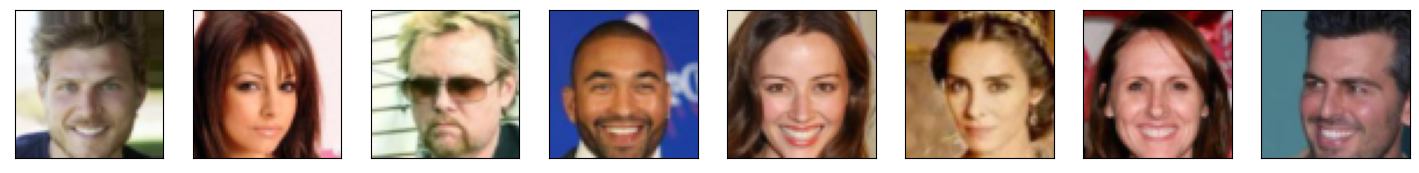

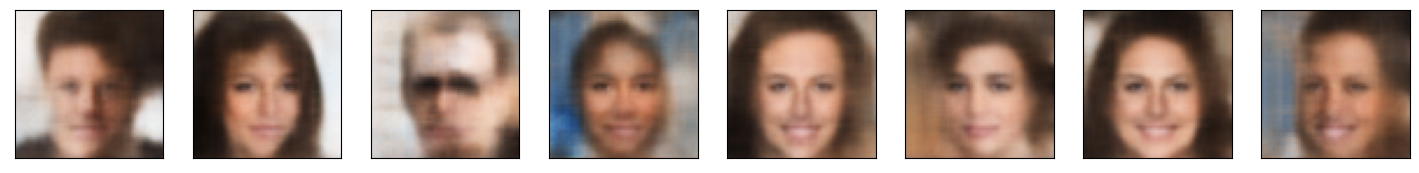

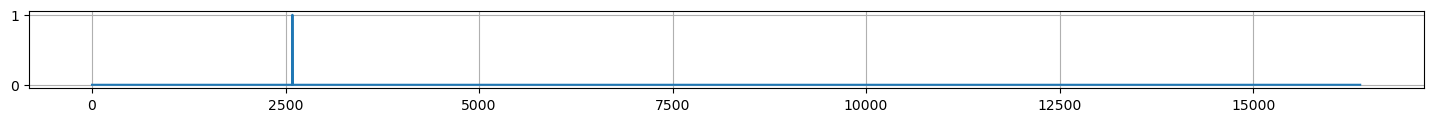

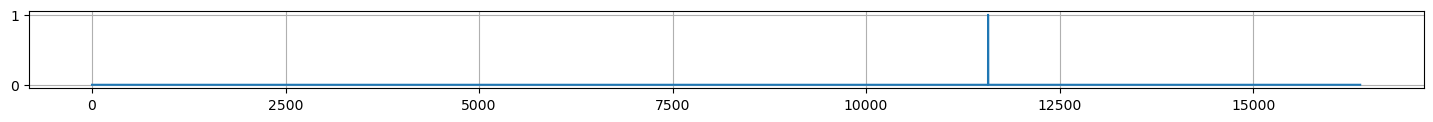

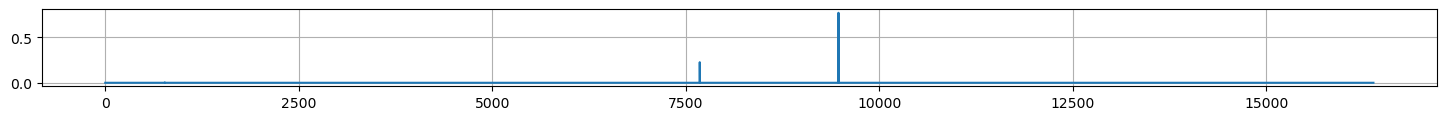

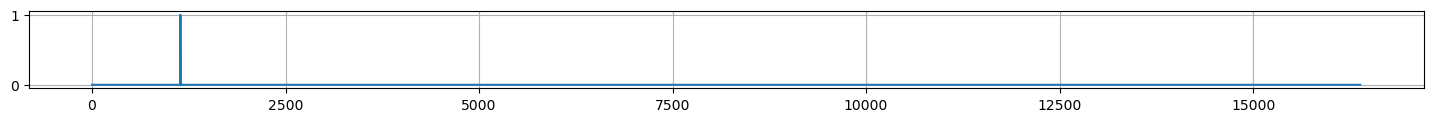

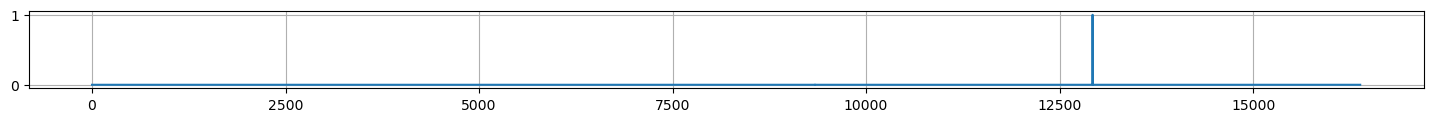

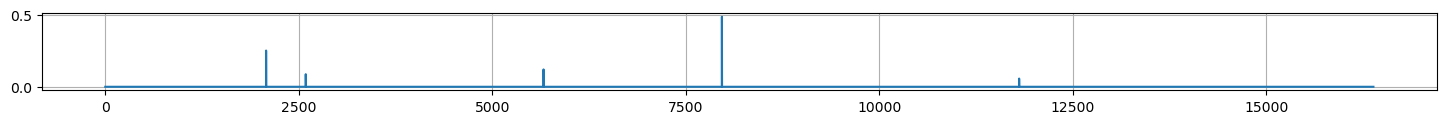

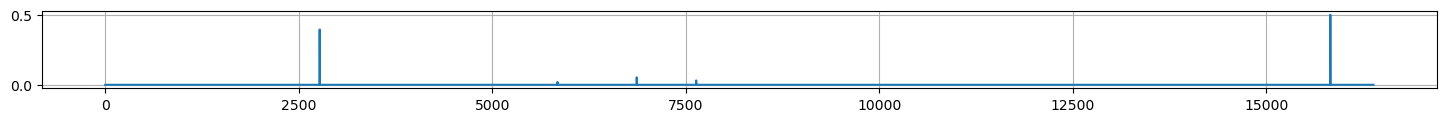

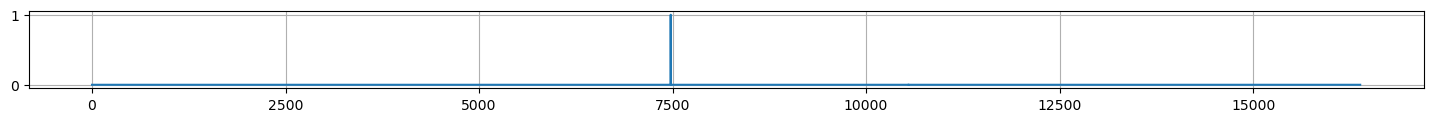

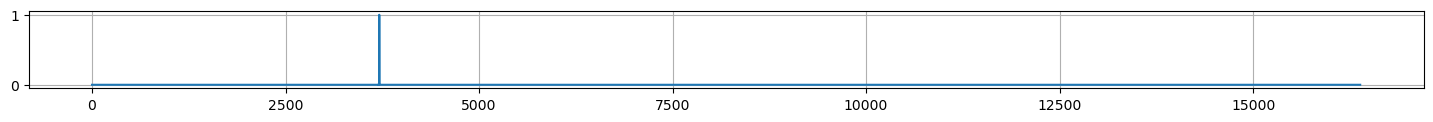

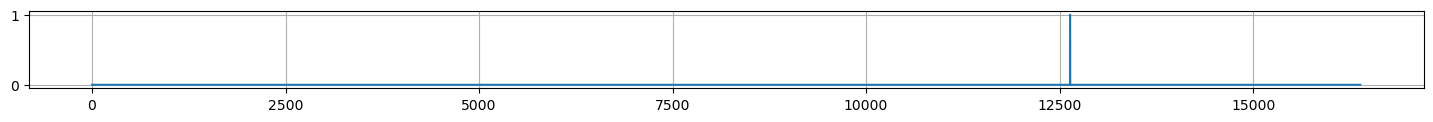

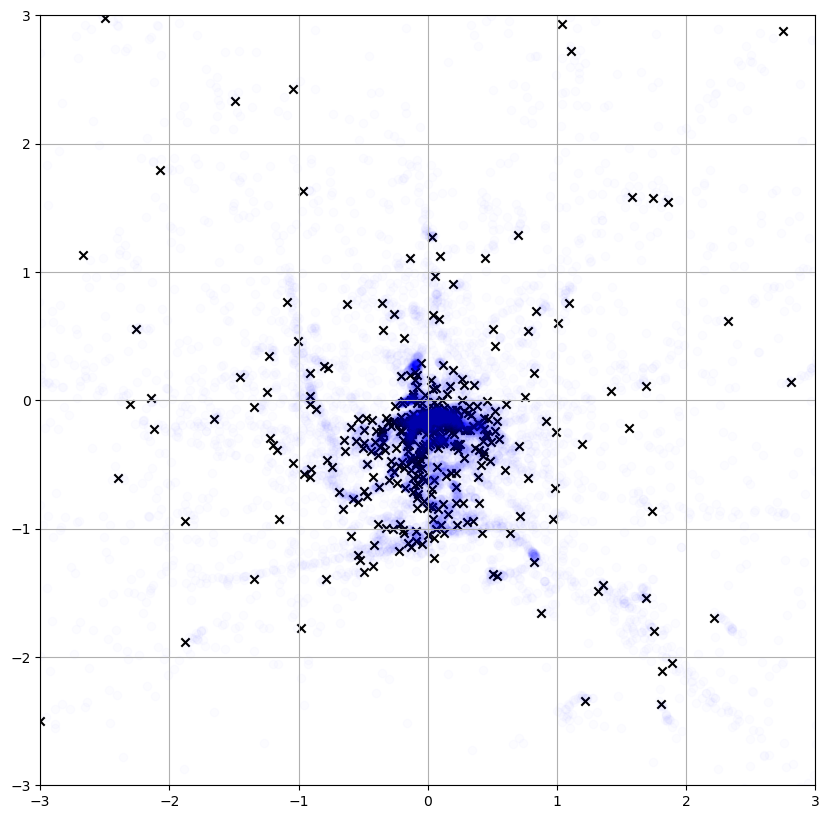

In [23]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show() 

In [32]:
from tqdm import tqdm

belongs = []
for i, batch in tqdm(enumerate(train_loader)):
    data = preprocess(batch)

    # Forward
    model.eval()
    data = model(data, latent_temp=1)
    belongs.append(data['belong'])

    if i > 2:
        break

3it [00:00, 10.83it/s]


In [33]:
belongs = torch.stack(belongs, dim=0)
print(belongs.shape)

torch.Size([4, 16384, 512])


In [34]:
(belongs.sum(dim=[0, 1]) > 0).sum()

tensor(512, device='cuda:0')